## Exploratory Data Analysis
Conducting some analysis of the available data to identify some potential modeling considerations for the Kaggle bike rental predictions playground. 

## Set Up

### Initial Checks
Loading the data and taking a cursory look at the raw available columns.

In [52]:
# setup
import pandas as pd
import numpy as np
import plotnine as pn
import seaborn as sb
import matplotlib.pyplot as plt

train = pd.read_csv("data/train.csv", parse_dates = True)
test = pd.read_csv("data/test.csv", parse_dates = True)
data = pd.concat([train, test]) 

In [53]:
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# Display basic information about the dataset
print("\nDataset Information:")
print(data.info())

# Display summary statistics of the dataset
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


First 5 rows of the dataset:
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0     3.0        13.0   16.0  
1        80        0.0     8.0        32.0   40.0  
2        80        0.0     5.0        27.0   32.0  
3        75        0.0     3.0        10.0   13.0  
4        75        0.0     0.0         1.0    1.0  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      -------

Observations: 
-   No apparent missing data from any of the potential predictor variables
-   Categorical/binary variables in season, holiday, working day, weather
-   Continuous/count variables in temp, atemp, humidity, windspeed
-   Training includes the hourly data for the first 20 days of a month, and we need to predict hourly counts for day 20
    -   could be worth calculating the "day of the month"
    -   also the month in addition to season

### Wrangling
Based on the cursory look at the data, there are a couple of additional columns I'd like to be able to explore. Namely: day of the month, day of the week and month. 

In [67]:
def wrangle(df):
    # Convert the 'date' column to datetime
    df['datetime'] = pd.to_datetime(df['datetime'])

    df['hour'] = df.datetime.dt.hour

    # Extract day of the month
    df['day_of_month'] = df['datetime'].dt.day

    # Extract day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
    df['day_of_week'] = df['datetime'].dt.dayofweek

    # Extract dayo of the year
    df['day_of_year'] = df["datetime"].dt.day_of_year
    # Extract the month (1 = January, 2 = February, ..., 12 = December)
    df['month'] = df['datetime'].dt.month

    # Extract the year
    df['year'] = df['datetime'].dt.year

    return df

train_ = wrangle(train)
test_ = wrangle(test)
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10886 non-null  datetime64[ns]
 1   season        10886 non-null  int64         
 2   holiday       10886 non-null  int64         
 3   workingday    10886 non-null  int64         
 4   weather       10886 non-null  int64         
 5   temp          10886 non-null  float64       
 6   atemp         10886 non-null  float64       
 7   humidity      10886 non-null  int64         
 8   windspeed     10886 non-null  float64       
 9   casual        10886 non-null  int64         
 10  registered    10886 non-null  int64         
 11  count         10886 non-null  int64         
 12  hour          10886 non-null  int32         
 13  day_of_month  10886 non-null  int32         
 14  day_of_week   10886 non-null  int32         
 15  month         10886 non-null  int32 

In [68]:
# function to facet a set of variables together for univariate or bivariate 
def melt_plot(x, y, data, title, scales = "free", geom_type = pn.geom_point()):
    if y is not None:
        id_vars = ["datetime",y]
        aes_set = pn.aes("value", y)
    else:
        id_vars = ["datetime"]
        aes_set = pn.aes("value")

    data_long = data.melt(id_vars=id_vars, value_vars=x)
    plot = (
        pn.ggplot(data_long, aes_set) 
        + geom_type
        + pn.facet_wrap("~variable", scales=scales)   
        + pn.labs(title=title)
        )   
    return plot

## Univariate
Now that I've wrangled a couple of additional potential features, I'll conduct univariate assessment of all of the variables. 

Analysis: appears to be a standard count distribution, maybe Poisson would be a good assumption to make?

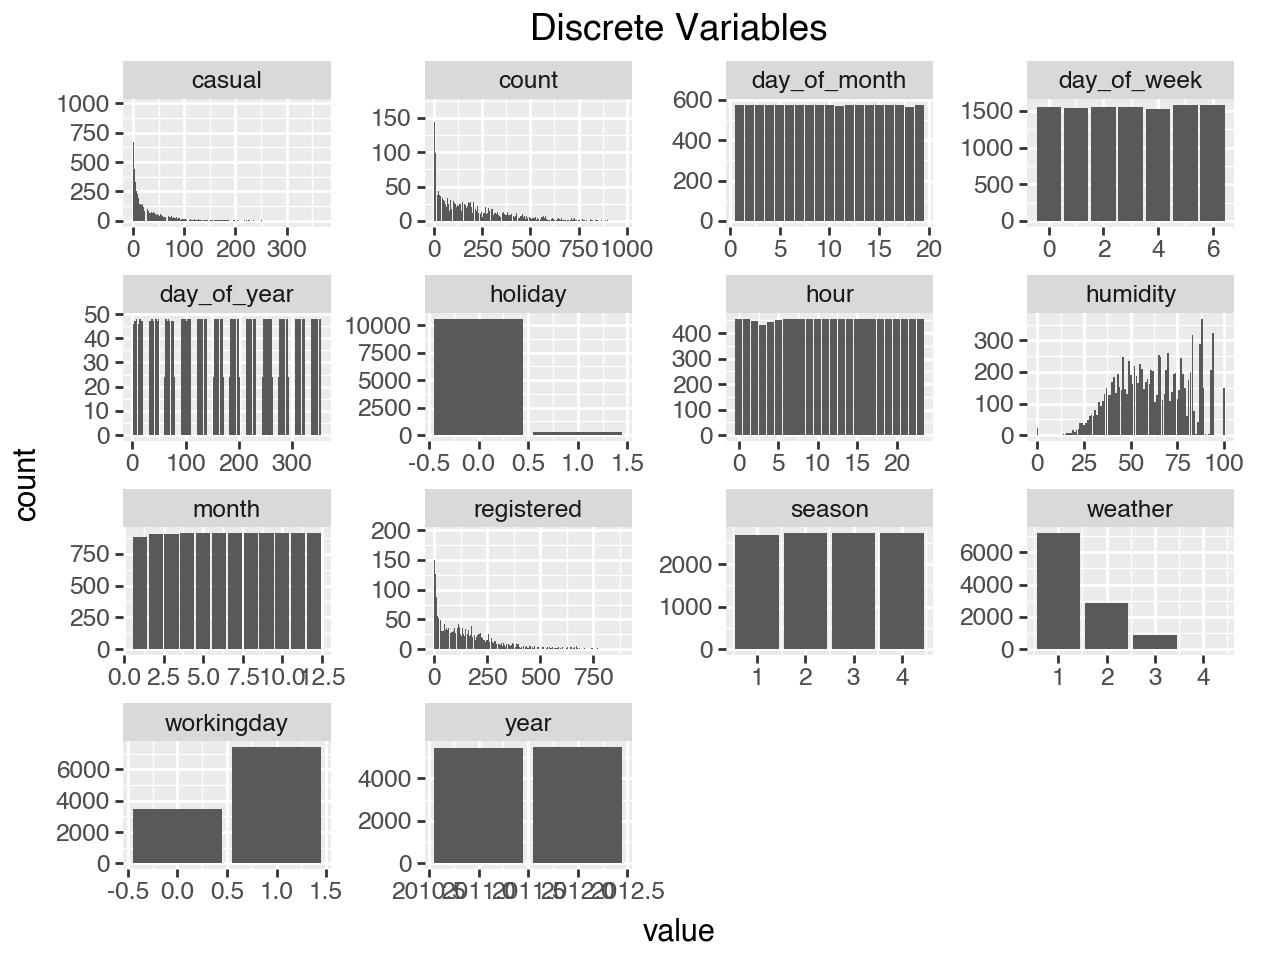

In [69]:
# now looking at discrete variables
disc = train.select_dtypes(include=['int64','int32']).columns
melt_plot(x=disc, y=None, data=train, title="Discrete Variables", geom_type=pn.geom_bar())

Analysis: 
-   a lot of expected results here, although there is a slight inequity in months and season
-   rental count variables (`count`, `casual`, `registered`) have fairly standard looking count distributions (if we need to make a distributional assumption later)
-   humidity has a good central curve with a 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 63'. Pick better value with 'binwidth'.


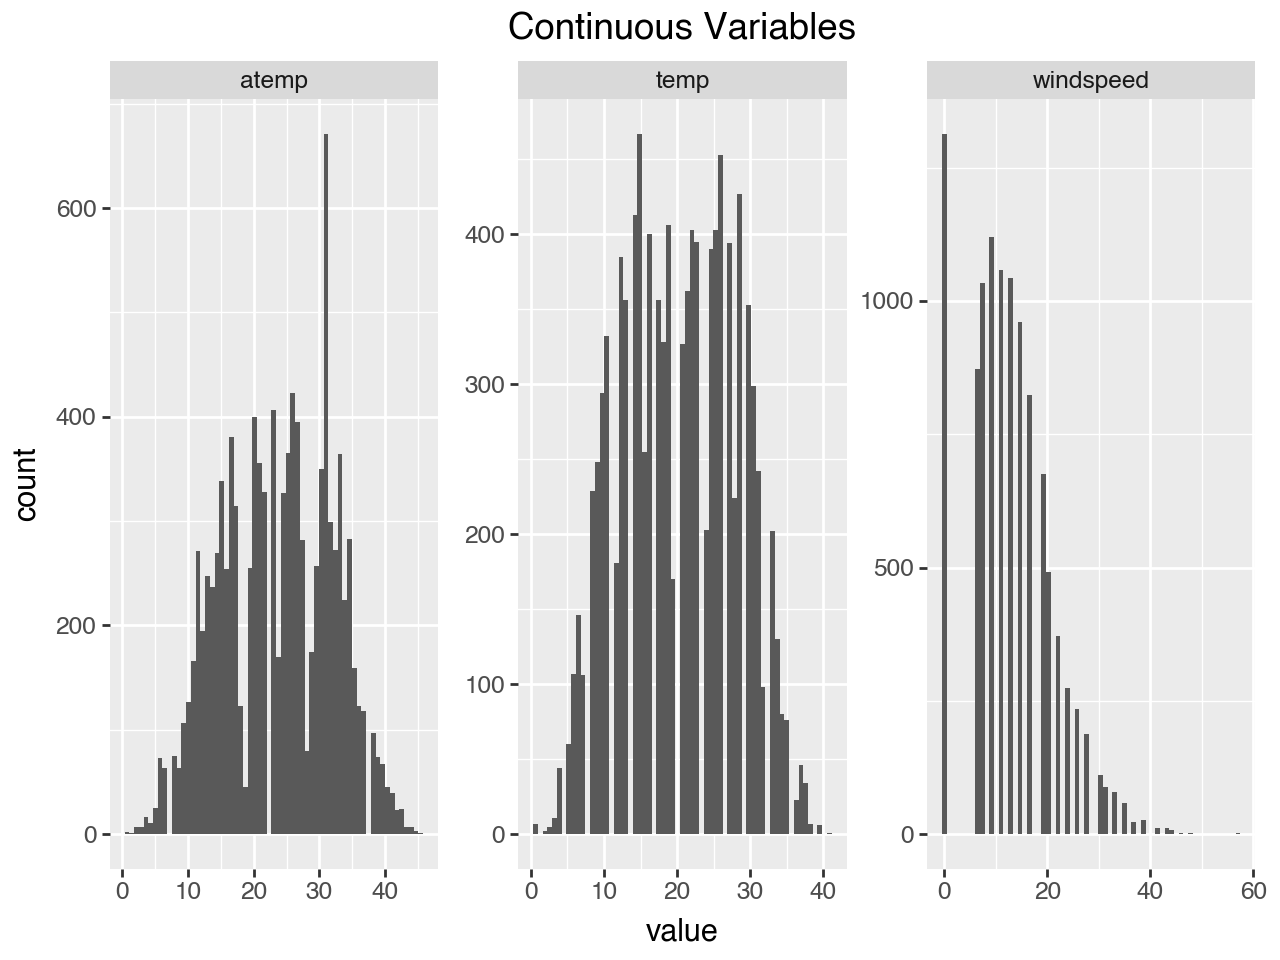

In [57]:
# now looking at interval variables
cont = train.select_dtypes(include='float64').columns
melt_plot(x=cont, y=None, data=train, title="Continuous Variables", geom_type=pn.geom_histogram())

Analysis:
-   felt temperature (`atemp`) seems like a nice, slightly wide normal distribution
-   actual temperature (`temp`)` is good, a bit bimodal
-   windspeet is interesting, a large percentage of zeros. Is this natural, or is this a result of the data sometimes not being collected?

## Bivariate

### Collinearity
Next, I'll take a look assess bivariate relationships an identify any potential collinearity

In [71]:
# creating a correlation matrix to asess pairwise collinearity
train_.drop(["casual","registered","datetime","date"], axis=1).corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day_of_month,day_of_week,month,year,day_of_year
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439,-0.006546,0.001729,-0.010553,0.971524,-0.004797,0.970196
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393,-0.000354,-0.015877,-0.191832,0.001731,0.012021,0.001134
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594,0.002780,0.009829,-0.704267,-0.003394,-0.002482,-0.003024
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655,-0.022740,-0.007890,-0.047692,0.012144,-0.012548,0.011746
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.145430,0.015551,-0.038466,0.257589,0.061226,0.255887
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.140343,0.011866,-0.040235,0.264173,0.058540,0.262245
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.278011,-0.011335,-0.026507,0.204537,-0.078606,0.203155
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369,0.146631,0.036157,-0.024804,-0.150192,-0.015221,-0.148062
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000,0.400601,0.019826,-0.002283,0.166862,0.260403,0.168056
hour,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,0.400601,1.000000,0.001132,-0.002925,-0.006818,-0.004234,-0.006735


Analysis:
-   `temp` and `atemp` might be a concern with a 0.98 pearson correlation, the goal should probably be to pick one or the other
-   similarly, `month` and `season` have a very high linear correlation and represent a very similar thing
-   `hour` has a very moderate-strong linear relationship with the response variable
-   `hour` also has weak-moderate linear relationships with `temperature`, `humidity`, and `windspeed`
-   some other moderate potentiall collinearities may be present such as `season` and `temp`, `season` and `humidity`, `month` and `temp`, `month`, and `humidity`
-   `temp`, `atemp`, and `humidity` have the strongest linear correlations (still moderate) with the response variable `count`
-   there are weak linear relationships between `month` and `season` with `count`

### Bivariate Plots
No I'm looking for any potential relationsh

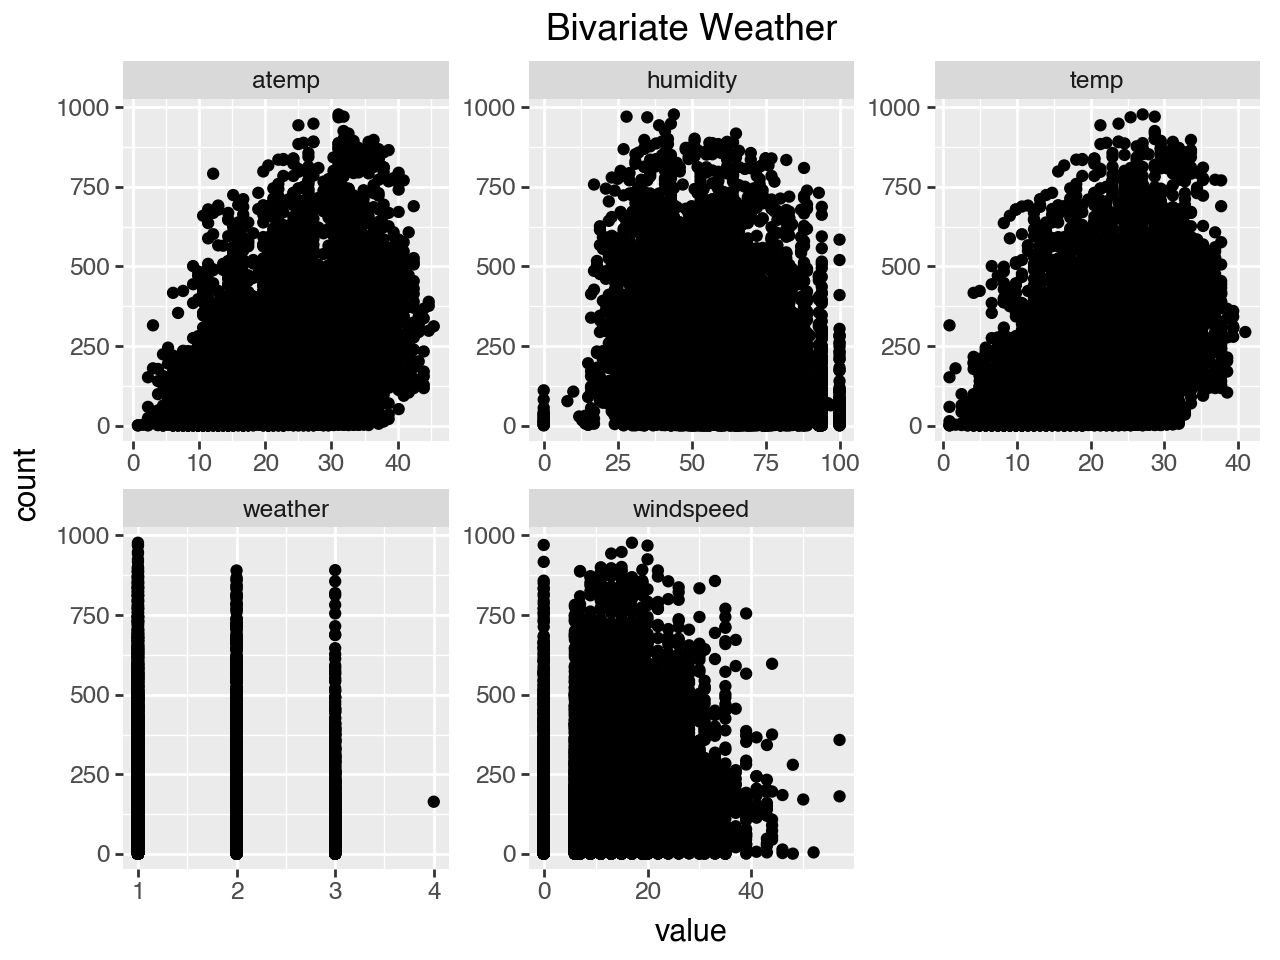

In [72]:
# count and weather vars
weather = ['temp','atemp','humidity','windspeed','weather']
melt_plot(x=weather, y="count", data=train, title="Bivariate Weather", geom_type=pn.geom_point())


Analysis:
-   `atemp` and `temp` relationships with `count` are almost identical
-   `humidity` has something curvilinear
-   `windspeed` is slightly more interpretable
-   `weather` could have something

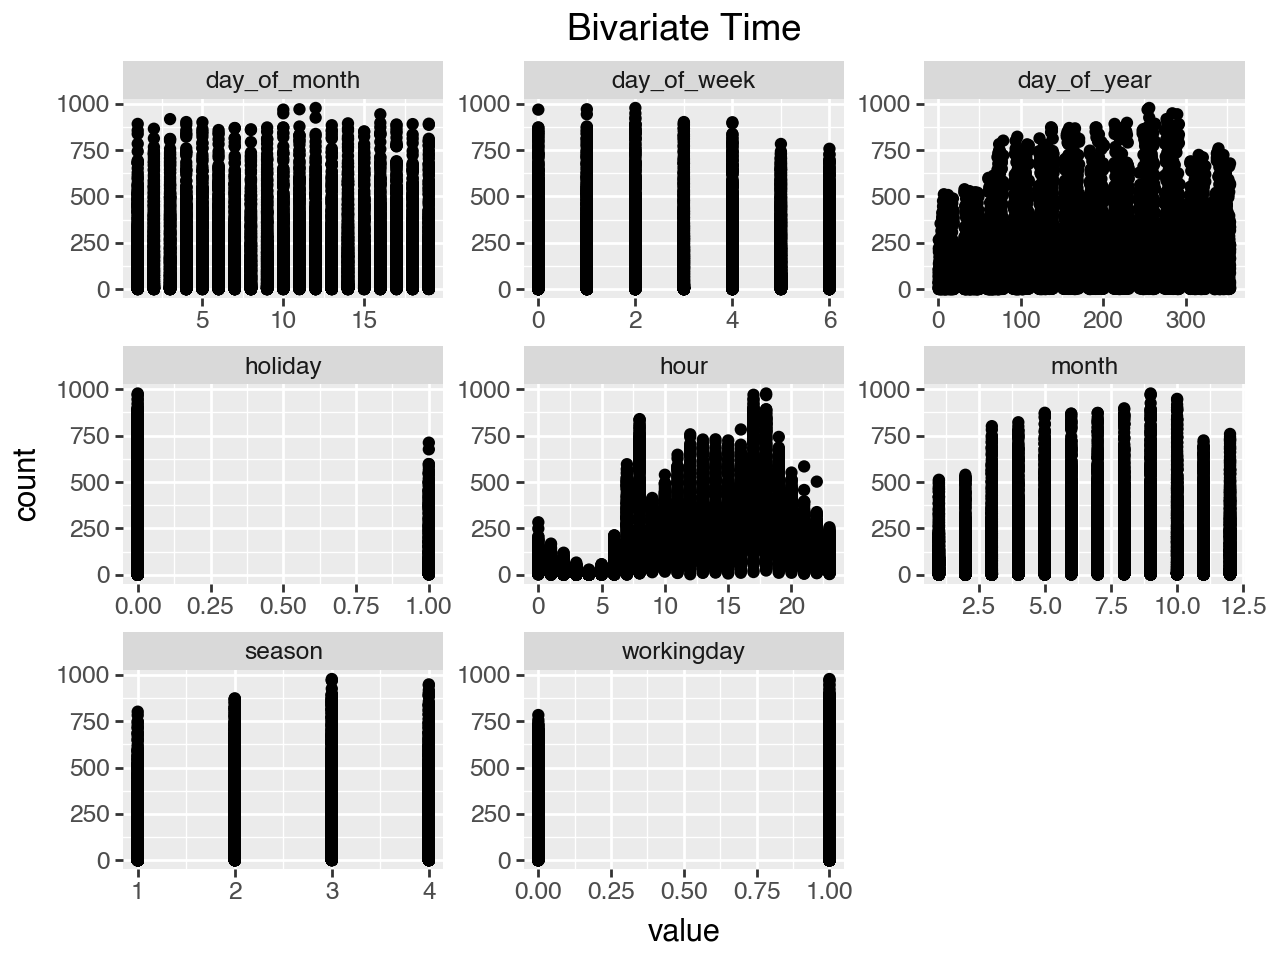

In [73]:
# count and date vars
time = ["hour","day_of_week","day_of_month","day_of_year","month","season","holiday","workingday"]
    
melt_plot(x=time, y="count", data=train, title="Bivariate Time", geom_type=pn.geom_point())

Analysis:
-   lots of pattern/curvilinear stuff happening here, this makes sense with time data!
-   `day_of_month` has some fluctuations, but seems minor
-   `day_of_week` seems to slightly decrease over the course of the week, may be a result of the `workingday` split that we see (corr = -0.70)
-   `holiday` seems powerful
-   `hour` makes a lot of sense, peaks during commute hours
-   `month` and `season` are really showing a consistency. I wonder if `month` will still be the better option?

### Trends and Seasonality
Looking at how bike rental behaviors have changed over time (trend) and whether there are any seasonal patterns that have shifted

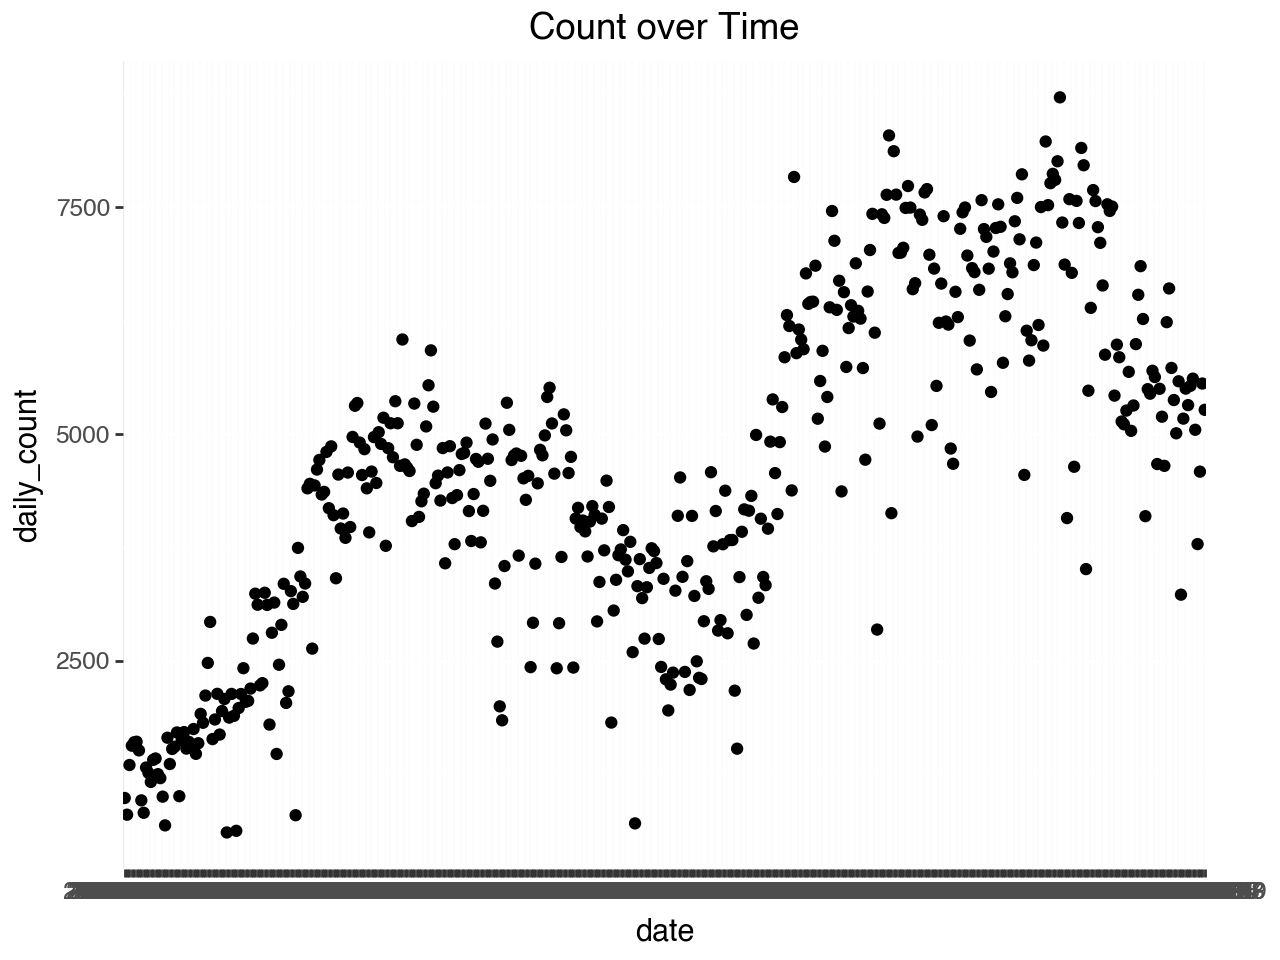

In [62]:
# looking at the trend over time
train_["date"] = train_["datetime"].dt.date
train_daily = train_.groupby(
    by="date"
    ).agg(
    daily_count = ("count","sum")
    ).reset_index()

(
    pn.ggplot(train_daily, pn.aes("date","daily_count"))
    + pn.geom_point() 
    + pn.labs(title="Count over Time")
)

Analysis: there is definitely an upwards trend in addition to a seasonal component

## Finalize Datasets

In [74]:
train_clean = train_.drop(["registered","casual"], axis=1)
test_clean = test_

In [75]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10886 non-null  datetime64[ns]
 1   season        10886 non-null  int64         
 2   holiday       10886 non-null  int64         
 3   workingday    10886 non-null  int64         
 4   weather       10886 non-null  int64         
 5   temp          10886 non-null  float64       
 6   atemp         10886 non-null  float64       
 7   humidity      10886 non-null  int64         
 8   windspeed     10886 non-null  float64       
 9   count         10886 non-null  int64         
 10  hour          10886 non-null  int32         
 11  day_of_month  10886 non-null  int32         
 12  day_of_week   10886 non-null  int32         
 13  month         10886 non-null  int32         
 14  year          10886 non-null  int32         
 15  date          10886 non-null  object

Exporting the wrangled datasets for use in model selection. 

In [76]:
train_clean.to_csv("data/train_clean.csv")
test_clean.to_csv("data/test_clean.csv")